In [1]:
# Importing the necessary libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import datetime
from operator import itemgetter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score
from sklearn.mixture import GaussianMixture


In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 400)

In [3]:
df = pd.read_pickle("./Data/dataframefull.pickle")
df_user = pd.read_pickle("./Data/users.pickle")
df_month = pd.read_pickle("./Data/months.pickle")

In [4]:
df_user_std = df_user.copy()
df_user_mm = df_user.copy()

In [5]:
#df_user.to_pickle('./Data/usercomp.pkl', compression='xz')

In [6]:
df_user.head()

,user_id,revenue,women_article,men_article,kids_article,homeandliving_article,avg_shop_cart,total_purchases,avg_cart_itemcount,monday,times_bought_monday,tuesday,times_bought_tuesday,wednesday,times_bought_wednesday,thursday,times_bought_thursday,friday,times_bought_friday,saturday,times_bought_saturday,sunday,times_bought_sunday,user_type,country,region,city,device_category,device_browser,device_os,country_slim
0,1,147.01,6,1,0,0,73.505,2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,first,Germany,Lower Saxony,Varel,desktop,Firefox,Windows,Germany
1,2,208.34,8,0,0,0,208.340,1,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,first,Germany,Mecklenburg-Vorpommern,Stralsund,desktop,Internet Explorer,Windows,Germany
2,3,84.11,0,1,0,0,84.110,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Lower Saxony,Buchholz in der Nordheide,tablet,Safari,iOS,Germany
3,4,62.32,1,4,0,0,62.320,1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Berlin,Berlin,desktop,Chrome,Windows,Germany
4,5,89.89,0,0,4,0,44.945,2,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Schleswig-Holstein,Neumunster,tablet,Safari,iOS,Germany


In [7]:
df_month.head()

,year_month,revenue,monthly_growth_revenue,avg_shop_cart,avg_cart_itemcount,active_customers,total_purchases,women_article,men_article,kids_article,homeandliving_article,revenue_first,revenue_established,first_user_count,established_user_count,retained_user_count,retention_rate,ratio_first_to_established
0,201711,5.268517e+06,0.000000,103.495016,3.466743,46985,50906,96910,61491,14107,999,5.268517e+06,0.00,46985,0,46985,1.000000,0.000000
1,201712,4.983451e+06,-0.054108,90.652698,3.284649,50004,54973,95202,64962,15461,1806,4.619641e+06,363809.47,46799,3205,3205,0.064095,14.601872
2,201801,3.717325e+06,-0.254066,87.034361,3.661563,38221,42711,89365,52416,10983,1100,3.216473e+06,500851.97,33596,4625,3141,0.082180,7.264000
3,201802,3.056483e+06,-0.177773,90.680675,3.791995,30837,33706,67535,42438,14910,795,2.526812e+06,529670.62,26114,4723,2520,0.081720,5.529113
4,201803,6.210612e+06,1.031947,108.247849,3.966274,52209,57374,139458,66852,18202,964,5.122223e+06,1088389.01,44512,7697,2797,0.053573,5.783032


In [8]:
user_dum = pd.get_dummies(df_user.drop(columns=["user_id", "region", "city","country"]))
#region and city need to be dropped as the computing power needed to do this exceeds the given

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
user_scale = scaler.fit_transform(user_dum)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
user_scale_MM = scaler.fit_transform(user_dum)

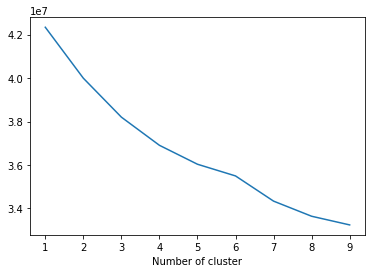

In [11]:
from sklearn.cluster import KMeans

sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_scale)
    #df_user["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

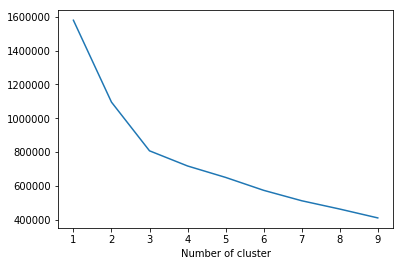

In [12]:
from sklearn.cluster import KMeans

sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_scale_MM)
    #df_user["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

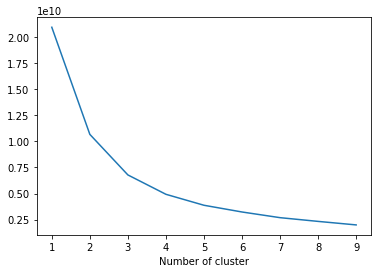

In [13]:
from sklearn.cluster import KMeans

sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_dum)
    #df_user["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [14]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final



## cluster with user_dum unscaled

In [15]:
kmeans = KMeans(n_clusters=4, max_iter=1000)
kmeans.fit(user_dum)
df_user['cluster'] = kmeans.predict(user_dum)

In [16]:
ordered_by_rev = order_cluster('cluster', 'revenue',df_user,False)

In [18]:
ordered_by_rev.groupby('cluster').describe()

avg_cart_itemcount                                               \
                     count      mean       std  min       25%       50%   
cluster                                                                   
0                   3356.0  7.344891  4.395411  1.0  4.333333  6.333333   
1                  38896.0  8.677976  5.147687  1.0  4.750000  7.500000   
2                 154700.0  5.629230  3.292602  1.0  3.000000  5.000000   
3                 425665.0  2.396767  1.690613  1.0  1.000000  2.000000   

                         avg_shop_cart                                     \
               75%   max         count        mean         std        min   
cluster                                                                     
0         9.255682  62.0        3356.0  212.023195  130.956998  34.235172   
1        11.333333  54.0       38896.0  270.350333  132.308473  27.126111   
2         7.000000  35.0      154700.0  162.064581   58.700592  20.408462   
3         3.000000  29.0      425665.0   56.167927   28.102707   0.000000   

                                                       friday            \
                25%         50%        75%      max     count      mean   
cluster                                                                   
0        127.275402  183.485714  263.46375  2099.47    3356.0  1.196365   
1        158.219167  254.944167  362.93000  1001.06   38896.0  0.337438   
2        126.030000  152.455000  198.28000   311.40  154700.0  0.191597   
3         33.610000   50.410000   75.61000   122.53  425665.0  0.153731   

                                            homeandliving_article            \
              std  min  25%  50%  75%   max                 count      mean   
cluster                                                                       
0        1.404018  0.0  0.0  1.0  2.0  15.0                3356.0  0.188319   
1        0.613390  0.0  0.0  0.0  1.0   6.0               38896.0  0.049414   
2        0.426265  0.0  0.0  0.0  0.0   6.0              154700.0  0.028093   
3        0.366923  0.0  0.0  0.0  0.0   4.0              425665.0  0.020718   

                                            kids_article                      \
              std  min  25%  50%  75%   max        count      mean       std   
cluster                                                                        
0        1.005348  0.0  0.0  0.0  0.0  19.0       3356.0  2.674911  7.359176   
1        0.443752  0.0  0.0  0.0  0.0  20.0      38896.0  0.995604  3.531950   
2        0.302393  0.0  0.0  0.0  0.0  13.0     154700.0  0.512256  2.114738   
3        0.197159  0.0  0.0  0.0  0.0  10.0     425665.0  0.281068  1.170731   

                                   men_article                             \
         min  25%  50%  75%    max       count       mean        std  min   
cluster                                                                     
0        0.0  0.0  0.0  1.0  125.0      3356.0  11.489571  16.225999  0.0   
1        0.0  0.0  0.0  0.0   85.0     38896.0   4.988431   6.813669  0.0   
2        0.0  0.0  0.0  0.0   44.0    154700.0   2.391409   3.571307  0.0   
3        0.0  0.0  0.0  0.0   37.0    425665.0   1.000982   1.652091  0.0   

                                  monday                                     \
         25%  50%   75%    max     count      mean       std  min  25%  50%   
cluster                                                                       
0        1.0  5.0  16.0  209.0    3356.0  1.000596  1.255450  0.0  0.0  1.0   
1        0.0  2.0   8.0   76.0   38896.0  0.289413  0.564928  0.0  0.0  0.0   
2        0.0  0.0   4.0   37.0  154700.0  0.170026  0.401347  0.0  0.0  0.0   
3        0.0  0.0   2.0   27.0  425665.0  0.135858  0.347810  0.0  0.0  0.0   

                     revenue                                              \
         75%   max     count         mean         std     min        25%   
cluster                                                

In [ ]:
df_user.groupby(["cluster"]).agg({
    "revenue": "mean",
    "women_article": "count",
    "men_article": "count",
    "kids_article": "count",
    "homeandliving_article": "count",
    "avg_shop_cart": "mean",
    "total_purchases": "mean",
    "avg_cart_itemcount": "mean",
    "monday": "mean",
    "tuesday": "mean",
    "wednesday": "mean",
    "thursday": "mean",
    "friday": "mean",
    "saturday": "mean",
    "sunday": "mean",
    "user_type": "mode"  
})#.round(0)

cluster 0 and 1 denote only about 2% of the customers, but these have the highest value <br>
cluster 2 has 57000 users , about 9% of the customers, are still valueable, mostly those customers that purchase more often<br>
cluster 3 a bit more than a average of 1 time customers, but with a way higher avg. purchase value than cluster 4, abput 27% <br> 
cluster 4 customers who mostly bought only once, about 61%

## cluster with user_dum std scale

In [44]:
kmeans = KMeans(n_clusters=4, max_iter=1000)
kmeans.fit(user_scale)
df_user_std['cluster'] = kmeans.predict(user_scale)

In [45]:
ordered_by_rev_std = order_cluster('cluster', 'revenue',df_user_std,False)

In [46]:
ordered_by_rev_std.groupby('cluster').describe()

avg_cart_itemcount                                                  \
                     count      mean       std  min   25%       50%    75%   
cluster                                                                      
0                  82852.0  4.063799  2.807534  1.0  2.00  3.333333  5.000   
1                      4.0  5.625000  3.637192  3.0  3.75  4.250000  6.125   
2                 240777.0  3.779629  3.375357  1.0  2.00  3.000000  5.000   
3                 298984.0  3.366352  3.089804  1.0  1.00  2.000000  4.000   

              avg_shop_cart                                                   \
          max         count        mean         std   min        25%     50%   
cluster                                                                        
0        62.0       82852.0  105.181735   72.756420   0.0  54.354583   85.82   
1        11.0           4.0  229.680000  193.510629  63.0  80.955000  190.51   
2        54.0      240777.0   98.552151   85.666727   0.0  40.330000   71.40   
3        38.0      298984.0   92.856744   81.141069   0.0  37.997500   67.21   

                              friday                                          \
              75%      max     count      mean       std  min  25%  50%  75%   
cluster                                                                        
0        135.0875  2099.47   82852.0  0.413364  0.683830  0.0  0.0  0.0  1.0   
1        339.2350   474.70       4.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
2        126.0300  1159.57  240777.0  0.145728  0.354958  0.0  0.0  0.0  0.0   
3        117.6300   975.48  298984.0  0.143426  0.352429  0.0  0.0  0.0  0.0   

              homeandliving_article                                          \
          max                 count      mean       std  min  25%  50%  75%   
cluster                                                                       
0        15.0               82852.0  0.051429  0.430543  0.0  0.0  0.0  0.0   
1         0.0                   4.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
2         2.0              240777.0  0.022411  0.229711  0.0  0.0  0.0  0.0   
3         3.0              298984.0  0.020275  0.214335  0.0  0.0  0.0  0.0   

              kids_article                                                 \
          max        count      mean       std  min  25%  50%  75%    max   
cluster                                                                     
0        20.0      82852.0  0.968824  3.359806  0.0  0.0  0.0  0.0  125.0   
1         0.0          4.0  0.000000  0.000000  0.0  0.0  0.0  0.0    0.0   
2        16.0     240777.0  0.296025  1.354488  0.0  0.0  0.0  0.0   44.0   
3        12.0     298984.0  0.317890  1.384229  0.0  0.0  0.0  0.0   37.0   

        men_article                                                    monday  \
              count      mean       std  min  25%  50%   75%    max     count   
cluster                                                                         
0           82852.0  3.580095  6.257612  0.0  0.0  1.0  5.00  209.0   82852.0   
1               4.0  5.750000  4.787136  0.0  3.0  6.0  8.75   11.0       4.0   
2          240777.0  1.649593  2.711750  0.0  0.0  0.0  2.00   50.0  240777.0   
3          298984.0  1.119786  2.193875  0.0  0.0  0.0  1.00   35.0  298984.0   

                                                        revenue              \
             mean       std  min  25%  50%  75%   max     count        mean   
cluster                                                                       
0        0.359509  0.629714  0.0  0.0  0.0  1.0  12.0   82852.0  328.795704   
1        0.000000  0.000000  0.0  0.0  0.0  0.0   0.0       4.0  251.415000   
2        0.134714  0.343299  0.0  0.0  0.0  0.0   2.0  240777.0  103.732071   
3        0.122167  0.328631  0.0  0.0  0.0  0.0   3.0  298984.0   98.007150   

                                                                saturday  \
                std   min     25%      50%     

seems that there is no good outcome whatsoever with a standardscaler.

## cluster with user_dum MM scale

In [47]:
kmeans = KMeans(n_clusters=3, max_iter=1000)
kmeans.fit(user_scale_MM)
df_user_mm['cluster'] = kmeans.predict(user_scale_MM)

In [48]:
ordered_by_rev_mm = order_cluster('cluster', 'revenue',df_user_mm,False)

In [49]:
ordered_by_rev_mm.groupby('cluster').describe()

avg_cart_itemcount                                                \
                     count      mean       std  min  25%  50%  75%   max   
cluster                                                                    
0                 191440.0  3.393987  2.991140  1.0  1.0  2.0  4.0  43.0   
1                 275434.0  3.831695  3.321247  1.0  2.0  3.0  5.0  62.0   
2                 155743.0  3.519423  3.121613  1.0  1.0  2.5  4.5  42.0   

        avg_shop_cart                                                   \
                count       mean        std  min        25%        50%   
cluster                                                                  
0            191440.0  92.638997  78.457662  0.0  39.979808  67.220000   
1            275434.0  99.554536  84.470537  0.0  42.010000  73.921667   
2            155743.0  96.644433  81.572287  0.0  41.170000  71.183333   

                            friday                                          \
            75%      max     count      mean       std  min  25%  50%  75%   
cluster                                                                      
0        117.64   975.48  191440.0  0.189882  0.439953  0.0  0.0  0.0  0.0   
1        127.71  2099.47  275434.0  0.178987  0.420349  0.0  0.0  0.0  0.0   
2        124.33  1138.39  155743.0  0.170589  0.405873  0.0  0.0  0.0  0.0   

              homeandliving_article                                          \
          max                 count      mean       std  min  25%  50%  75%   
cluster                                                                       
0         9.0              191440.0  0.021897  0.248694  0.0  0.0  0.0  0.0   
1        15.0              275434.0  0.026496  0.264316  0.0  0.0  0.0  0.0   
2        10.0              155743.0  0.027154  0.263069  0.0  0.0  0.0  0.0   

              kids_article                                                 \
          max        count      mean       std  min  25%  50%  75%    max   
cluster                                                                     
0        20.0     191440.0  0.404800  1.846313  0.0  0.0  0.0  0.0  125.0   
1        16.0     275434.0  0.370985  1.701499  0.0  0.0  0.0  0.0   85.0   
2        13.0     155743.0  0.429631  1.846337  0.0  0.0  0.0  0.0   59.0   

        men_article                                                   monday  \
              count      mean       std  min  25%  50%  75%    max     count   
cluster                                                                        
0          191440.0  1.377889  3.039600  0.0  0.0  0.0  2.0  195.0  191440.0   
1          275434.0  1.989014  3.652563  0.0  0.0  1.0  3.0  209.0  275434.0   
2          155743.0  1.393308  2.941176  0.0  0.0  0.0  2.0   84.0  155743.0   

                                                        revenue              \
             mean       std  min  25%  50%  75%   max     count        mean   
cluster                                                                       
0        0.159115  0.400926  0.0  0.0  0.0  0.0  10.0  191440.0  132.310767   
1        0.164664  0.402058  0.0  0.0  0.0  0.0  12.0  275434.0  131.711617   
2        0.147249  0.376460  0.0  0.0  0.0  0.0  11.0  155743.0  127.863360   

                                                          saturday            \
                std  min    25%    50%     75%       max     count      mean   
cluster                                                                        
0        170.899672  0.0  42.01  80.66  157.09   6267.30  191440.0  0.242906   
1        157.693459  0.0  44.52  84.02  159.65   6112.63  275434.0  0.193807   
2        166.397869  0.0  42.01  80.65  152.47  21205.01  155743.0  0.229808   

                                               sunday                      \
              std  min  25%  50%  75%   max     count      mean       std   
cluster                                                                     
0        0.510702  0.0  0.0  0.

## scores (easier?)

std

In [37]:
km_scores_std = []
km_silhouette_std = []
vmeasure_score_std =[]
db_score_std = []
for i in range(2,10):
    km = KMeans(n_clusters=i, random_state=0, n_jobs=-1).fit(user_scale)
    preds = km.predict(user_scale)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(user_scale)))
    km_scores_std.append(-km.score(user_scale))
    
    #silhouette = silhouette_score(user_scale,preds)
    #km_silhouette.append(silhouette)
    #print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(user_scale,preds)
    db_score_std.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    
    #v_measure = v_measure_score(y,preds)
    #vmeasure_score.append(v_measure)
    #print("V-measure score for number of cluster(s) {}: {}".format(i,v_measure))
    #print("-"*100)

Score for number of cluster(s) 2: -39993673.539483
Davies Bouldin score for number of cluster(s) 2: 3.084420864314706
Score for number of cluster(s) 3: -38151677.00138855
Davies Bouldin score for number of cluster(s) 3: 2.6684086752203484
Score for number of cluster(s) 4: -36844947.6261874
Davies Bouldin score for number of cluster(s) 4: 2.429067656575418
Score for number of cluster(s) 5: -35599691.71899528
Davies Bouldin score for number of cluster(s) 5: 1.9427752156956994
Score for number of cluster(s) 6: -34881720.19371477
Davies Bouldin score for number of cluster(s) 6: 1.8968626133034645
Score for number of cluster(s) 7: -34293283.84473896
Davies Bouldin score for number of cluster(s) 7: 1.4524160115970393
Score for number of cluster(s) 8: -33471260.010843866
Davies Bouldin score for number of cluster(s) 8: 1.812607099127524
Score for number of cluster(s) 9: -32226040.981937606
Davies Bouldin score for number of cluster(s) 9: 1.6124422071110631


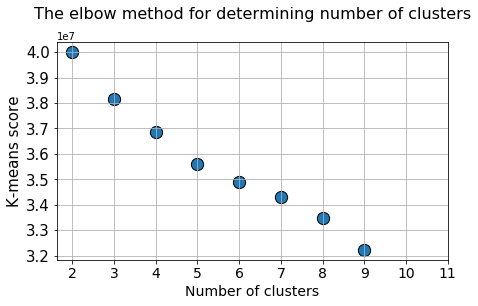

In [38]:
plt.figure(figsize=(7,4))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,10)],y=km_scores_std,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

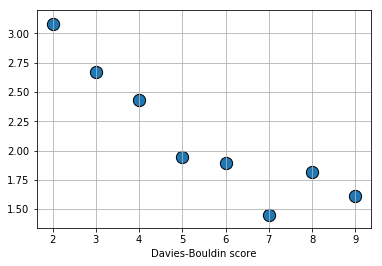

In [39]:
plt.scatter(x=[i for i in range(2,10)],y=db_score_std,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Davies-Bouldin score")
plt.show()

minmax

In [34]:
km_scores_mm = []
km_silhouette_mm = []
vmeasure_score_mm =[]
db_score_mm = []
for i in range(2,10):
    km = KMeans(n_clusters=i, random_state=0, n_jobs=-1).fit(user_scale_MM)
    preds = km.predict(user_scale_MM)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(user_scale_MM)))
    km_scores_mm.append(-km.score(user_scale_MM))
    
    #silhouette = silhouette_score(user_scale_MM,preds)
    #km_silhouette.append(silhouette)
    #print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(user_scale_MM,preds)
    db_score_mm.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    
    #v_measure = v_measure_score(y,preds)
    #vmeasure_score.append(v_measure)
    #print("V-measure score for number of cluster(s) {}: {}".format(i,v_measure))
    #print("-"*100)

Score for number of cluster(s) 2: -1095069.1920719314
Davies Bouldin score for number of cluster(s) 2: 1.4223826510462672
Score for number of cluster(s) 3: -807111.1736564833
Davies Bouldin score for number of cluster(s) 3: 1.139270900019804
Score for number of cluster(s) 4: -717477.6897347833
Davies Bouldin score for number of cluster(s) 4: 1.2859295751264421
Score for number of cluster(s) 5: -648748.6352908359
Davies Bouldin score for number of cluster(s) 5: 1.1553348617985502
Score for number of cluster(s) 6: -573544.1493252423
Davies Bouldin score for number of cluster(s) 6: 1.0547451540839987
Score for number of cluster(s) 7: -521801.546469498
Davies Bouldin score for number of cluster(s) 7: 1.2800319938336828
Score for number of cluster(s) 8: -457140.9813684305
Davies Bouldin score for number of cluster(s) 8: 1.1304327975590316
Score for number of cluster(s) 9: -410621.05875132605
Davies Bouldin score for number of cluster(s) 9: 1.075923649874048


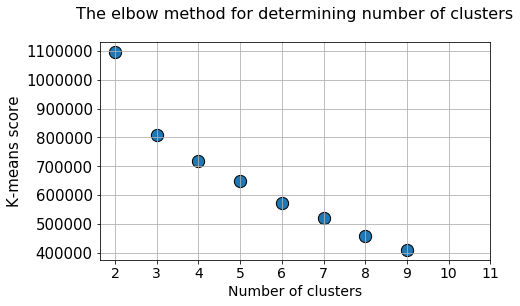

In [35]:
plt.figure(figsize=(7,4))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,10)],y=km_scores_mm,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

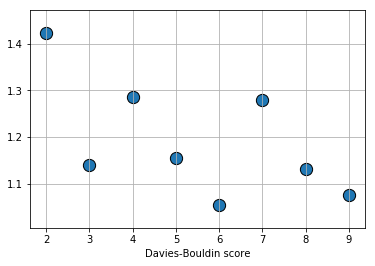

In [36]:
plt.scatter(x=[i for i in range(2,10)],y=db_score_mm,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Davies-Bouldin score")
plt.show()

## Gaussian Mixture

In [33]:
'''gm_bic= []
gm_score=[]
for i in range(2,12):
    gm = GaussianMixture(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(user_scale)
    print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(user_scale)))
    print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(user_scale)))
    print("-"*100)
    gm_bic.append(-gm.bic(user_scale))
    gm_score.append(gm.score(user_scale))'''

'gm_bic= []\ngm_score=[]\nfor i in range(2,12):\n    gm = GaussianMixture(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(user_scale)\n    print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(user_scale)))\n    print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(user_scale)))\n    print("-"*100)\n    gm_bic.append(-gm.bic(user_scale))\n    gm_score.append(gm.score(user_scale))'

In [ ]:
'''plt.figure(figsize=(7,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic),s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()'''